In [1]:
import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile
import time
import ignite
import torch
import pandas as pd
from sklearn.model_selection import KFold
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt


from monai.config import print_config
from monai.data import (
decollate_batch,
DataLoader,
CacheDataset
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss, DeepSupervisionLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet, SegResNetDS, SwinUNETR
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    Orientationd,
    Spacingd,
    CropForegroundd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    RandShiftIntensityd,
    RandAffined,
    RandFlipd,
    SaveImaged,
    ToTensord,
)
from monai.utils.misc import ImageMetaKey
print(torch.__version__)

/WAVE/apps/el8/conda/envs/JupyterHub/20231011-CUDA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/WAVE/users/unix/smalladi/.conda/envs/venv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/WAVE/users/unix/smalladi/.conda/envs/venv/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


1.13.1+cu117


In [2]:
torch.cuda.is_available()

True

In [2]:
metrics_dir = 'metrics/10-11/'
root_dir = '/WAVE/users/unix/smalladi/varian_ml/Hecktor22'
data_dir = 'hecktor2022_training/hecktor2022'
resampled_ct_path = '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/resampled/imagesTr'
resampled_pt_path = '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/resampled/imagesTr'
resampled_label_path = '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/resampled'

train_images = sorted(
    glob.glob(os.path.join(resampled_ct_path, "*_CT*")))
train_images2 = sorted(
    glob.glob(os.path.join(resampled_pt_path, "*_PT*")))
train_labels = sorted(
    glob.glob(os.path.join(resampled_label_path, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "image2": pet_image, 'label': label_name}
    for image_name, pet_image, label_name in zip(train_images, train_images2, train_labels)
]
# temp = [{'image': '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/hecktor2022/resampled_largerCt/MDA-184__CT_nobrain.nii.gz', 'image2': '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/hecktor2022/resampled_largerPt/MDA-184__PT_nobrain.nii.gz', 'label':'/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/hecktor2022/resampled_largerlabel/MDA-184__CT_nobrain.nii.gz'}]
# data_dicts.remove(temp[0])
print(len(train_images))
print(len(train_images2))
print(len(train_labels))
len(data_dicts)

524
524
524


524

In [3]:
import random
x=[i for i in range(524)]
# print(x)
# random.shuffle(x)
# print(x)
train_index,val_index,test_index=x[:470],x[470:510],x[510:]
train_files=[]
val_files=[]
test_files=[]
for i in train_index:
    train_files.append(data_dicts[i])
for i in val_index:
    val_files.append(data_dicts[i])
for i in test_index:
    test_files.append(data_dicts[i])

In [4]:
print(len(train_files))
print(len(val_files))
print(len(test_files))

470
40
14


In [5]:
t_files = train_files[:20]
v_files = val_files[:10]
print(len(v_files))

10


In [6]:
ct_a_min = -200
ct_a_max = 400
pt_a_min = 0
pt_a_max = 25
crop_samples = 2
input_size = [96, 96, 96]
modes_2d = ['bilinear', 'bilinear', 'nearest']
p = 0.5
strength = 1
image_keys = ["image", "image2", "label"]

train_transforms = Compose([
    LoadImaged(keys=["image", "image2", "label"]),
    EnsureChannelFirstd(keys = ["image", "image2", "label"]),
    Orientationd(keys=["image", "image2", "label"], axcodes="RAS"),
    # Spacingd(
    #     keys=image_keys,
    #     pixdim=(1, 1, 1),
    #     mode=modes_2d,
    # ),
    ScaleIntensityRanged(keys=['image'], a_min=ct_a_min, a_max=ct_a_max, b_min=0.0, b_max=1.0, clip=True),
    ScaleIntensityRanged(keys=['image2'], a_min=pt_a_min, a_max=pt_a_max, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=image_keys, source_key='image'),
    RandCropByPosNegLabeld(
        keys=image_keys,
        label_key='label',
        spatial_size=input_size,
        pos=1,
        neg=1,
        num_samples=crop_samples,
        image_key='image',
        image_threshold=0,
    ),
    RandAffined(keys=image_keys, prob=p,
                    translate_range=(round(10 * strength), round(10 * strength), round(10 * strength)),
                    padding_mode='border', mode=modes_2d),
    RandAffined(keys=image_keys, prob=p, scale_range=(0.10 * strength, 0.10 * strength, 0.10 * strength),
                    padding_mode='border', mode=modes_2d),
    RandFlipd(keys=["image", "image2", "label"], prob=p/3, spatial_axis=0),
    RandFlipd(keys=["image", "image2", "label"], prob=p/3, spatial_axis=1),
    RandFlipd(keys=["image", "image2", "label"], prob=p/3, spatial_axis=2),
    RandShiftIntensityd(
            keys=["image", "image2"],
            offsets=0.10,
            prob=p,
        ),
    ToTensord(keys=["image", "image2", "label"])
])
val_transforms = Compose([
    LoadImaged(keys=["image", "image2", "label"]),
    EnsureChannelFirstd(keys = ["image", "image2", "label"]),
    Orientationd(keys=["image", "image2", "label"], axcodes="RAS"),
    # Spacingd(
    #     keys=image_keys,
    #     pixdim=(1, 1, 1),
    #     mode=modes_2d,
    # ),
    ScaleIntensityRanged(keys=['image'], a_min=ct_a_min, a_max=ct_a_max, b_min=0.0, b_max=1.0, clip=True),
    ScaleIntensityRanged(keys=['image2'], a_min=pt_a_min, a_max=pt_a_max, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=image_keys, source_key='image'),
    ToTensord(keys=["image", "image2", "label"])
])

orig_transforms = Compose([
    LoadImaged(keys=["image", "image2", "label"])
])

In [7]:
train_ds = CacheDataset(data=t_files, transform=train_transforms, cache_rate=0.0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=v_files, transform=val_transforms, cache_rate=0.01)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

In [7]:
# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.0)
# train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

# val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.01)
# val_loader = DataLoader(val_ds, batch_size=1, num_workers=2) 

In [ ]:
temp = [{'image': '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/hecktor2022/resampled_largerCt/MDA-184__CT_nobrain.nii.gz', 'image2': '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/hecktor2022/resampled_largerPt/MDA-184__PT_nobrain.nii.gz', 'label':'/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/hecktor2022/resampled_largerlabel/MDA-184__CT_nobrain.nii.gz'}]
temp1_ds = CacheDataset(data=temp, transform=train_transforms, cache_rate=0.0)
temp1_loader = DataLoader(temp1_ds, batch_size=1, shuffle=True, num_workers=1)

temp2_ds = CacheDataset(data=temp, transform=val_transforms, cache_rate=0.0)
temp2_loader = DataLoader(temp2_ds, batch_size=1, num_workers=1)

for data in temp2_loader:
    key = 'label'
    tensor = data[key]
    count_0 = np.count_nonzero(tensor == 0)
    count_1 = np.count_nonzero(tensor == 1)
    count_2 = np.count_nonzero(tensor == 2)
    count_3 = np.count_nonzero(tensor == 3)
    
    print("Count of 0's:", count_0)
    print("Count of 1's:", count_1)
    print("Count of 2's:", count_2)
    print("Count of 3's:", count_3)
    # print(tensor.shape)
    # Define the values to check for (0, 1, and 2)
    # values_to_check = [0, 1, 2]
    
    # Check if the tensor has any values other than the specified values
    # has_other_values = not np.all(np.isin(tensor, values_to_check))
    # if has_other_values:
        # print(tensor.meta[ImageMetaKey.FILENAME_OR_OBJ])
    unique_values = np.unique(tensor)
    print(unique_values)
print("Done")

In [10]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return (model,
            optimizer,
            checkpoint['epoch'],
            checkpoint['best_metric'],
            checkpoint['train_time'],
            checkpoint['epoch_loss_values'],
            checkpoint['metric_values'],
            checkpoint['metric_values_1'],
            checkpoint['metric_values_2']
            )

In [8]:
device = torch.device("cuda:0")
n_classes = 3
n_channels = 2
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    init_filters=16,
    blocks_up=[1, 1, 1],
    in_channels = n_channels,
    out_channels= n_classes,
    dropout_prob = 0.2
).to(device)

In [ ]:
model

In [11]:
val_interval = 1
VAL_AMP = True
lr = 0.0002
momentum = 0
sigmoid = False
weight_decay = 1.0e-05
T_0 = 40
n_classes = 3
n_channels = 2
input_size = (96, 96, 96)
max_epochs = 2
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    init_filters=16,
    blocks_up=[1, 1, 1],
    in_channels = n_channels,
    out_channels= n_classes,
    dropout_prob = 0.2
).to(device)

# model = SegResNetDS(
#   init_filters = 32,
#   blocks_down = [1, 2, 2, 4, 4, 4],
#   norm = 'BATCH',
#   in_channels = n_channels,
#   out_channels = n_classes,
#   dsdepth = 4
# ).to(device)


# model = SwinUNETR(
#         img_size=input_size,
#         in_channels=n_channels,
#         out_channels=n_classes,
#         feature_size=48,
#         use_checkpoint=True,
#     ).to(device)

# loss_function = DiceCELoss(to_onehot_y=True, softmax=True, include_background=False, sigmoid=False, squared_pred=True, smooth_nr=0,
#   smooth_dr=1.0e-05)
loss_function = DiceLoss(softmax=True, to_onehot_y=True)
# loss_function = DeepSupervisionLoss(loss_function)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002,  weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
dice_metric = DiceMetric(include_background=False, reduction='mean', get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch", get_not_nans=False)
post_label = AsDiscrete(to_onehot=n_classes)
post_pred = AsDiscrete(argmax=True, to_onehot=n_classes)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True
start_epoch = 0
ckp_path = os.path.join(metrics_dir, 'checkpoint.pt')

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=input_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


In [ ]:
# folds = 5
# kfold = KFold(n_splits=folds, shuffle=True)

In [24]:
import shutil
def save_ckp(state, is_best, metrics_dir):
    f_path = os.path.join(metrics_dir, 'checkpoint.pt')
    torch.save(state, f_path)
    if is_best:
        best_fpath = os.path.join(metrics_dir, 'best_model.pt')
        shutil.copyfile(f_path, best_fpath)

In [12]:
def save_image(img_tensor, target_shape, affine, img_path):
    test_output = torch.softmax(img_tensor, 1).cpu().numpy()
    test_output = np.argmax(test_output, axis=1).astype(np.int16)[0]
    test_output = resample_3d(test_output, target_shape)
    nib.save(     
            nib.Nifti1Image(test_output.astype(np.int16), affine), img_path
        )

In [14]:
roi_size = (192, 192, 192)
sw_batch_size = 2
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
metric_values_1 = list()
metric_values_2 = list()
best_metrics_epochs_and_time = [[], [], []]
total_start = time.time()
train_time = 0
# for fold, (train_ids, test_ids) in enumerate(kfold.split(data_dicts)):
#     print(f'FOLD {fold}')
#     print('--------------------------------')

# ckp_path = os.path.join(metrics_dir, 'checkpoint.pt')
# (
#     model,
#     optimizer,
#     start_epoch,
#     best_metric,
#     train_time,
#     epoch_loss_values,
#     metric_values,
#     metric_values_1,
#     metric_values_2
#     ) = load_ckp(ckp_path, model, optimizer)

max_epochs = 2
for epoch in range(start_epoch, max_epochs):
    is_best = False
    epoch_start = time.time()
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch + 1, max_epochs))
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputct, inputpt, labels = (
            batch_data['image'].to(device),
            batch_data['image2'].to(device), 
            batch_data['label'].to(device)
        )
        inputs = torch.concat([inputct, inputpt], axis=1)
        optimizer.zero_grad()
        # try:
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        # except Exception as e:
        #     print(labels.meta[ImageMetaKey.FILENAME_OR_OBJ])
        #     print(e)
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    model.eval()
    image_no = 0
    with torch.no_grad():
        for val_data in val_loader:
            image_no += 1
            val_inputct, val_inputpt, val_label = (
                val_data["image"].to(device),
                val_data["image2"].to(device),
                val_data["label"].to(device),
            )
            val_inputs = torch.concat([val_inputct, val_inputpt], axis=1)
            # try:
            val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
            # except Exception as e:
                # print(labels.meta[ImageMetaKey.FILENAME_OR_OBJ])
                # print(e)
            val_label_list = decollate_batch(val_label)
            val_label_convert = [post_label(val_label_tensor) for val_label_tensor in val_label_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

            # print(val_label.meta[ImageMetaKey.FILENAME_OR_OBJ])
            # img_path =  os.path.join(output_directory, "val_infered" + str(image_no) + ".nii.gz")
            # _, _, h, w, d = val_label.shape
            # target_shape = (h, w, d)
            # affine = val_data["label_meta_dict"]["affine"].numpy()
            # print(affine)
            # test_output = torch.softmax(val_outputs, 1).cpu().numpy()
            # test_output = np.argmax(test_output, axis=1).astype(np.int16)[0]
            # test_output = resample_3d(test_output, target_shape)
            # nib.save(     
            #         nib.Nifti1Image(test_output.astype(np.int16), affine), os.path.join(output_directory, img_name)
            #     )

            # img_name = "val_gt" + str(image_no) + ".nii.gz"
            # _, _, h, w, d = val_label.shape
            # target_shape = (h, w, d)
            # affine = val_data["label_meta_dict"]["affine"].numpy()
            # test_output = torch.softmax(val_labels, 1).cpu().numpy()
            # test_output = np.argmax(test_output, axis=1).astype(np.int16)[0]
            # test_output = resample_3d(test_output, target_shape)
            # nib.save(     
            #         nib.Nifti1Image(test_output.astype(np.int16), affine), os.path.join(output_directory, img_name)
            #     )

            value = dice_metric(y_pred=val_output_convert, y=val_label_convert)
            dice_metric_batch(y_pred=val_output_convert, y=val_label_convert) 
            print("Dice metrics:", value[0][0], value[0][1])
        metric = dice_metric.aggregate().item()
        metric_values.append(metric)
        metric_batch = dice_metric_batch.aggregate()
        metric_1 = metric_batch[0].item()
        metric_values_1.append(metric_1)
        metric_2 = metric_batch[1].item()
        metric_values_2.append(metric_2)
        dice_metric.reset()
        dice_metric_batch.reset()

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            best_metrics_epochs_and_time[0].append(best_metric)
            best_metrics_epochs_and_time[1].append(best_metric_epoch)
            best_metrics_epochs_and_time[2].append(time.time() - total_start)
            is_best = True
            print("saved new best metric model")
        print(
            f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            f" 1: {metric_1:.4f} 2: {metric_2:.4f}"
            f"\nbest mean dice: {best_metric:.4f}"
            f" at epoch: {best_metric_epoch}"
        )
    train_time += (time.time() - epoch_start)
    checkpoint = {
        'epoch': epoch + 1,
        'best_metric': best_metric,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_time': train_time,
        'epoch_loss_values': epoch_loss_values,
        'metric_values': metric_values,
        'metric_values_1': metric_values_1,
        'metric_values_2': metric_values_2
    }

    save_ckp(checkpoint, is_best, metrics_dir)
    print(f"Epoch {epoch + 1} completed")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
Epoch 1/2
1/10, train_loss: 0.8172
2/10, train_loss: 0.7862


/WAVE/users/unix/smalladi/.local/lib/python3.9/site-packages/monai/transforms/utils.py:509: UserWarning: Num foregrounds 0, Num backgrounds 3325217, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


3/10, train_loss: 0.7712
4/10, train_loss: 0.7660
5/10, train_loss: 0.7730
6/10, train_loss: 0.7659
7/10, train_loss: 0.7682
8/10, train_loss: 0.7663
9/10, train_loss: 0.7720
10/10, train_loss: 0.7720
epoch 1 average loss: 0.7758
Dice metrics: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Dice metrics: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Dice metrics: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Dice metrics: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Dice metrics: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Dice metrics: tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
Dice metrics: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Dice metrics: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Dice metrics: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Dice metrics: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
saved new best metric model
current epoch: 1 current mean dice: 0.000

NameError: name 'save_ckp' is not defined

In [28]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.1744 at epoch: 10, total time: 6363.153431892395.


In [ ]:
best_metrics_epochs_and_time_df = pd.DataFrame(best_metrics_epochs_and_time)
epoch_loss_values_df = pd.DataFrame(epoch_loss_values)
metric_values_df = pd.DataFrame(metric_values)
metric_values_1_df = pd.DataFrame(metric_values_1)
metric_values_2_df = pd.DataFrame(metric_values_2)
best_metrics_epochs_and_time_df.to_csv(metrics_dir + "best_metrics_epochs_and_time.csv")
epoch_loss_values_df.to_csv(metrics_dir + "epoch_loss_values.csv")
metric_values_df.to_csv(metrics_dir + "metric_values.csv")
metric_values_1_df.to_csv(metrics_dir + "metric_values_1.csv")
metric_values_2_df.to_csv(metrics_dir + "metric_values_2.csv")

0.3116997643311818
0.7287260890007019
0.7079921364784241
0.7544156312942505


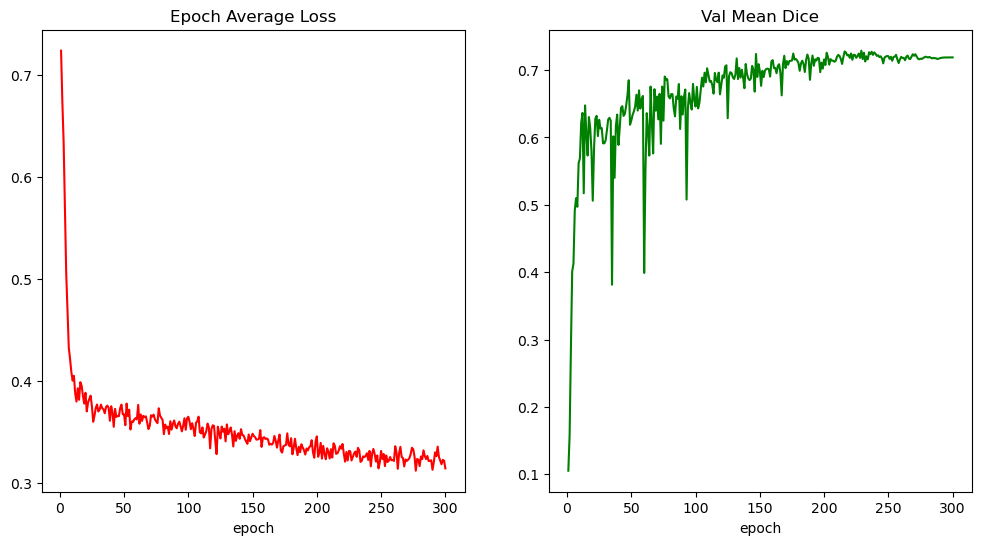

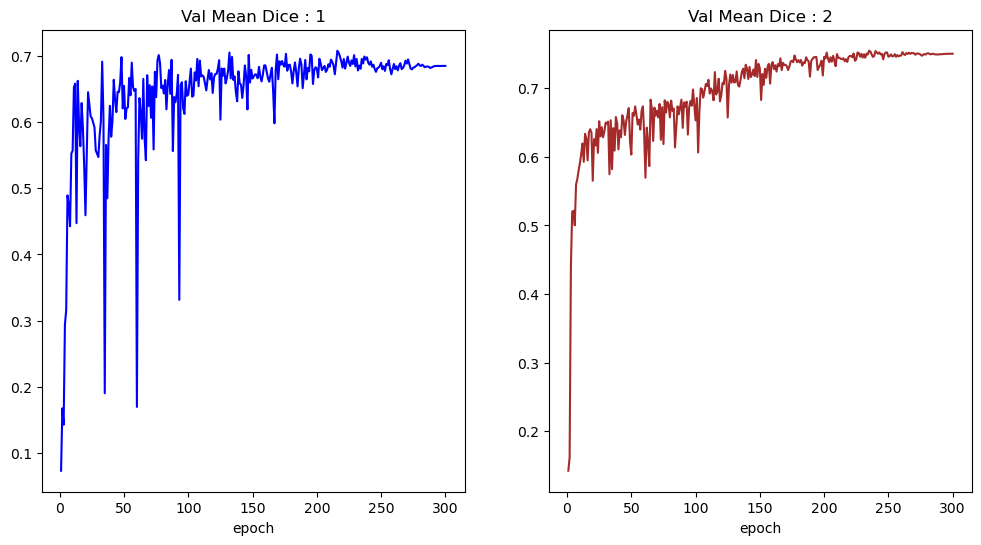

In [12]:
import matplotlib.pyplot as plt
metrics_dir = "metrics/10-26_300"
epoch_loss_values = pd.read_csv(os.path.join(metrics_dir, "epoch_loss_values.csv"), header=None)
# print(epoch_loss_values[1][1:])
metric_values = pd.read_csv(os.path.join(metrics_dir, "metric_values.csv"), header=None)
metric_values_1 = pd.read_csv(os.path.join(metrics_dir, "metric_values_1.csv"), header=None)
metric_values_2 = pd.read_csv(os.path.join(metrics_dir, "metric_values_2.csv"), header=None)
print(min(epoch_loss_values[1][1:]))
print(max(metric_values[1][1:]))
print(max(metric_values_1[1][1:]))
print(max(metric_values_2[1][1:]))     
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values) - 1)]
y = epoch_loss_values[1][1:]
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [i + 1 for i in range(len(metric_values) - 1)]
y = metric_values[1][1:]
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Val Mean Dice : 1")
x = [i + 1 for i in range(len(metric_values_1) - 1)]
y = metric_values_1[1][1:]
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice : 2")
x = [i + 1 for i in range(len(metric_values_2) - 1)]
y = metric_values_2[1][1:]
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.show()

#### Test dataset

In [26]:
test_ds = CacheDataset(data=test_files, transform=val_transforms, cache_rate=0.0)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2)

orig_ds = CacheDataset(data=test_files, transform=orig_transforms, cache_rate=0.0)
orig_loader = DataLoader(orig_ds, batch_size=1, num_workers=2)

In [27]:
import scipy.ndimage as ndimage
def resample_3d(img, target_size):
    imx, imy, imz = img.shape
    tx, ty, tz = target_size
    zoom_ratio = (float(tx) / float(imx), float(ty) / float(imy), float(tz) / float(imz))
    img_resampled = ndimage.zoom(img, zoom_ratio, order=0, prefilter=False)
    return img_resampled

In [28]:
metrics_dir = "metrics/10-26_300"
output_directory = 'data/output/10-26'
slice_no = 90
best_fpath = os.path.join(metrics_dir, "best_model.pt")
best_model = torch.load(best_fpath)
model.load_state_dict(best_model['state_dict'])

<All keys matched successfully>

In [31]:
model.eval()
img  = 0
roi_size = (192, 192, 192)
sw_batch_size = 1
for test, orig in zip(test_loader, orig_loader):
    img += 1
    img_name = "test_pred_" + str(img) + ".nii.gz"
    with torch.no_grad():
        # select one image to evaluate and visualize the model output
        test_inputct = test["image"].to(device)
        test_inputpt = test["image2"].to(device)
        test_label = test["label"].to(device)
        print(test_label.meta[ImageMetaKey.FILENAME_OR_OBJ])
        _, _, h, w, d = test_label.shape
        target_shape = (h, w, d)
        test_affine = test["label_meta_dict"]["affine"].numpy()[0]
        print(test_affine)
        test_input = torch.concat([test_inputct, test_inputpt], axis=1)
        test_output = sliding_window_inference(test_input, roi_size, sw_batch_size, model)
        labels = torch.argmax(test_output, dim=1)
        labels = labels[0]
        # test_label_list = decollate_batch(test_label)
        # test_label_convert = [post_label(test_label_tensor) for test_label_tensor in test_label_list]
        # test_output_list = decollate_batch(test_output)
        # test_output_convert = [post_pred(test_output_tensor) for test_output_tensor in test_output_list]
        # value = dice_metric(y_pred=test_output_convert, y=test_label_convert)
        # value_batch = dice_metric_batch(y_pred=test_output_convert, y=test_label_convert) 
        # print("Dice metrics:", dice_metric.aggregate().item())
        # print("Dice metric batch:", dice_metric_batch.aggregate()[0].item(), dice_metric_batch.aggregate()[1].item()) 
        # print(test_label_convert[0].shape, test_output_convert[0].shape)
        # test_output_in = post_pred(test_output[0])
        # test_output = torch.softmax(test_output, 1).cpu().numpy()
        # test_output = np.argmax(test_output, axis=1).astype(np.int16)
        # test_output = resample_3d(test_output, target_shape)
        nib.save(     
                nib.Nifti1Image(labels.astype(np.int16), test_affine), os.path.join(output_directory, img_name)
            )
    # plt.figure("label", (6, 6))
    # for i in range(1):
    #     # plt.subplot(1, 1, i + 1)
    #     plt.title(f"label channel {i}")
    #     plt.imshow(test_label[0][i, :, :, slice_no].detach().cpu())
    # plt.show()
    # # visualize the 3 channels model output corresponding to this image
    # plt.figure("output", (18, 6))
    # for i in range(3):
    #     plt.subplot(1, 3, i + 1)
    #     plt.title(f"output channel {i}")
    #     plt.imshow(test_output_convert[0][i, :, :, slice_no].detach().cpu())
    # plt.show()

['/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/resampled/labelsTr/MDA-188_resampled.nii.gz']
[[  -1.            0.            0.           65.921875  ]
 [   0.           -1.            0.          182.4375    ]
 [   0.            0.            1.         -271.96154785]
 [   0.            0.            0.            1.        ]]
['/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/resampled/labelsTr/MDA-189_resampled.nii.gz']
[[  -1.            0.            0.           96.        ]
 [   0.           -1.            0.          166.03125   ]
 [   0.            0.            1.         -345.02163696]
 [   0.            0.            0.            1.        ]]
['/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/resampled/labelsTr/MDA-190_resampled.nii.gz']
[[  -1.            0.            0.           96.        ]
 [   0.           -1.            0.          127.75      ]
 [   0.            0.            1.         -333.78256226]
 [   0.            0.            0

In [31]:
model.eval()
img  = 0
roi_size = (192, 192, 192)
sw_batch_size = 1
for test, orig in zip(test_loader, orig_loader):
    img += 1
    img_name = "test_pred_" + str(img) + ".nii.gz"
    with torch.no_grad():
        # select one image to evaluate and visualize the model output
        test_inputct = test["image"].to(device)
        test_inputpt = test["image2"].to(device)
        test_label = test["label"].to(device)
        affine = orig["label_meta_dict"]["affine"].numpy()[0]
        print(test_label.meta[ImageMetaKey.FILENAME_OR_OBJ])
        # print(orig["label"].meta[ImageMetaKey.FILENAME_OR_OBJ])
        _, h, w, d = orig["label"].shape
        target_shape = (h, w, d)
        # affine = test_ds[0]["label_meta_dict"]["affine"].numpy()
        test_input = torch.concat([test_inputct, test_inputpt], axis=1)
        test_output = sliding_window_inference(test_input, roi_size, sw_batch_size, model)
        print(test_output.shape)
        labels = torch.argmax(test_output, dim=1)
        print(labels.shape)
        labels = labels.permute(1,2,3,0)
        print(labels.shape)
        labels_array = labels.cpu().numpy()
        nib.save(nib.Nifti1Image(labels_array.astype(np.int16), affine), 'labels.nii.gz')
        break

['/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/resampled/labelsTr/MDA-188_resampled.nii.gz']
torch.Size([1, 3, 192, 192, 192])
torch.Size([1, 192, 192, 192])
torch.Size([192, 192, 192, 1])


In [31]:
test_label.shape

torch.Size([1, 1, 240, 233, 240])

In [ ]:
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    init_filters=16,
    blocks_up=[1, 1, 1],
    in_channels = n_channels,
    out_channels= n_classes,
    dropout_prob = 0.2
).to(device)
slice_no = 100
img = 0
 
model.load_state_dict(torch.load(os.path.join(metrics_dir, "best_metric_model.pth")))
model.eval()
for batch in test_loader:
    img += 1
    with torch.no_grad():
        # select one image to evaluate and visualize the model output
        test_inputct = batch["image"].unsqueeze(0).to(device)
        test_inputpt = batch["image2"].unsqueeze(0).to(device)
        test_input = torch.concat([test_inputct, test_inputpt], axis=1)
        roi_size = (192, 192, 192)
        sw_batch_size = 4
        test_output = sliding_window_inference(test_input, roi_size, sw_batch_size, model)
        test_output = post_pred(test_output[0])
    plt.figure("label", (6, 6))
    for i in range(1):
        # plt.subplot(1, 1, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(test_ds[image_no]["label"][i, :, :, slice_no].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(test_output[i, :, :, slice_no].detach().cpu())
    plt.show()